In [1]:
import gensim

In [2]:

corpus = """Technological advances are about much more than the new electric car from Tesla or autonomous vehicles by Mercedes. It is much more than just advanced wrist jewelry from Apple and fitness trackers that can tell you what you ate two weeks ago.

For senior people, technological change can mean the difference between dependency and independence. Forget your Ubers and your social media; forget about Ultra HD TVs, virtual reality gadgets, and other ever-changing technology, as a senior, all these things mean nothing if you are going to be confined to a nursing home with no freedom to enjoy it all.

The kind of modern technological advancements that seniors need may not hit the headlines like the new rocket by SpaceX, but that does not mean that they are any less significant. To the seniors who need these gadgets, advanced wearable tech is fast becoming an integral part of their safety, health, and happiness."""

In [3]:
import nltk
from nltk import sent_tokenize

In [4]:
list_of_sentence = sent_tokenize(corpus)

In [5]:
list_of_sentence

['Technological advances are about much more than the new electric car from Tesla or autonomous vehicles by Mercedes.',
 'It is much more than just advanced wrist jewelry from Apple and fitness trackers that can tell you what you ate two weeks ago.',
 'For senior people, technological change can mean the difference between dependency and independence.',
 'Forget your Ubers and your social media; forget about Ultra HD TVs, virtual reality gadgets, and other ever-changing technology, as a senior, all these things mean nothing if you are going to be confined to a nursing home with no freedom to enjoy it all.',
 'The kind of modern technological advancements that seniors need may not hit the headlines like the new rocket by SpaceX, but that does not mean that they are any less significant.',
 'To the seniors who need these gadgets, advanced wearable tech is fast becoming an integral part of their safety, health, and happiness.']

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence).encode('utf-8'), deacc=True))  # deacc=True removes punctuations
        
data_words = list(sent_to_words(list_of_sentence))
print(data_words[:1])

[['technological', 'advances', 'are', 'about', 'much', 'more', 'than', 'the', 'new', 'electric', 'car', 'from', 'tesla', 'or', 'autonomous', 'vehicles', 'by', 'mercedes']]


In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['technological', 'advances', 'are', 'about', 'much', 'more', 'than', 'the', 'new', 'electric', 'car', 'from', 'tesla', 'or', 'autonomous', 'vehicles', 'by', 'mercedes']


In [8]:
import spacy
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_trigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['technological', 'advance', 'much', 'new', 'electric', 'car', 'tesla', 'autonomous', 'vehicle', 'mercede']]


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]


In [12]:
id2word[0]
corpus[:1][0][:10]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1)]

In [13]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('advance', 1),
  ('autonomous', 1),
  ('car', 1),
  ('electric', 1),
  ('mercede', 1),
  ('much', 1),
  ('new', 1),
  ('technological', 1),
  ('tesla', 1),
  ('vehicle', 1)]]

In [14]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [15]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.016*"tv" + 0.016*"thing" + 0.016*"headline" + 0.016*"advancement" + '
  '0.016*"virtual" + 0.016*"ultra" + 0.016*"uber" + 0.016*"kind" + '
  '0.016*"reality" + 0.016*"nursing"'),
 (1,
  '0.061*"mean" + 0.061*"headline" + 0.061*"hit" + 0.061*"kind" + 0.061*"less" '
  '+ 0.061*"need" + 0.061*"rocket" + 0.061*"significant" + 0.061*"spacex" + '
  '0.061*"advancement"'),
 (2,
  '0.016*"tv" + 0.016*"thing" + 0.016*"headline" + 0.016*"advancement" + '
  '0.016*"virtual" + 0.016*"ultra" + 0.016*"uber" + 0.016*"kind" + '
  '0.016*"reality" + 0.016*"nursing"'),
 (3,
  '0.016*"tv" + 0.016*"thing" + 0.016*"headline" + 0.016*"advancement" + '
  '0.016*"virtual" + 0.016*"ultra" + 0.016*"uber" + 0.016*"kind" + '
  '0.016*"reality" + 0.016*"nursing"'),
 (4,
  '0.016*"tv" + 0.016*"thing" + 0.016*"headline" + 0.016*"advancement" + '
  '0.016*"virtual" + 0.016*"ultra" + 0.016*"uber" + 0.016*"kind" + '
  '0.016*"reality" + 0.016*"nursing"'),
 (5,
  '0.016*"tv" + 0.016*"thing" + 0.016*"headline" 

In [16]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3625368392131418


In [17]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [18]:
dictionary = corpora.Dictionary(data_lemmatized )
doc_term_matrix = [dictionary.doc2bow(rev) for rev in data_lemmatized ]

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [20]:
vis = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)

In [21]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=data_lemmatized, start=2, limit=50, step=1)

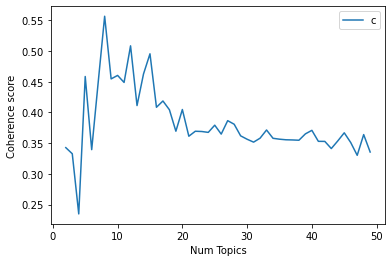

In [22]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

In [23]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3427
Num Topics = 3  has Coherence Value of 0.3328
Num Topics = 4  has Coherence Value of 0.2348
Num Topics = 5  has Coherence Value of 0.4586
Num Topics = 6  has Coherence Value of 0.3395
Num Topics = 7  has Coherence Value of 0.4487
Num Topics = 8  has Coherence Value of 0.5567
Num Topics = 9  has Coherence Value of 0.4547
Num Topics = 10  has Coherence Value of 0.4603
Num Topics = 11  has Coherence Value of 0.4489
Num Topics = 12  has Coherence Value of 0.5085
Num Topics = 13  has Coherence Value of 0.4113
Num Topics = 14  has Coherence Value of 0.4627
Num Topics = 15  has Coherence Value of 0.4955
Num Topics = 16  has Coherence Value of 0.4085
Num Topics = 17  has Coherence Value of 0.4187
Num Topics = 18  has Coherence Value of 0.4045
Num Topics = 19  has Coherence Value of 0.3695
Num Topics = 20  has Coherence Value of 0.4048
Num Topics = 21  has Coherence Value of 0.3613
Num Topics = 22  has Coherence Value of 0.3694
Num Topics = 23  has 

In [24]:
# Select the model and print the topics
optimal_model = model_list[7]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.016*"senior" + 0.016*"technological" + 0.016*"mean" + 0.016*"advance" + 0.016*"new" + 0.016*"much" + 0.016*"change" + 0.016*"wrist" + 0.016*"happiness" + 0.016*"independence"'),
 (1,
  '0.016*"technological" + 0.016*"senior" + 0.016*"mean" + 0.016*"advance" + 0.016*"new" + 0.016*"much" + 0.016*"change" + 0.016*"tell" + 0.016*"independence" + 0.016*"electric"'),
 (2,
  '0.016*"senior" + 0.016*"technological" + 0.016*"new" + 0.016*"advance" + 0.016*"change" + 0.016*"mean" + 0.016*"much" + 0.016*"people" + 0.016*"fitness" + 0.016*"gadget"'),
 (3,
  '0.016*"senior" + 0.016*"advance" + 0.016*"technological" + 0.016*"change" + 0.016*"mean" + 0.016*"much" + 0.016*"fitness" + 0.016*"people" + 0.016*"dependency" + 0.016*"gadget"'),
 (4,
  '0.061*"apple" + 0.061*"eat" + 0.061*"ago" + 0.061*"advanced" + 0.061*"much" + 0.061*"week" + 0.061*"tracker" + 0.061*"jewelry" + 0.061*"wrist" + 0.061*"tell"'),
 (5,
  '0.065*"technological" + 0.065*"much" + 0.065*"mercede" + 0.065*"new" + 0.065*"au

In [25]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(optimal_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.173254  0.091824       1        1  36.883783
8      0.020546 -0.173119       2        1  33.016473
4     -0.145292  0.102980       3        1  13.715537
5     -0.068663 -0.037037       4        1  12.443251
7      0.006665  0.004712       5        1   0.788191
0      0.003373  0.002660       6        1   0.788191
1      0.003373  0.002660       7        1   0.788191
2      0.003373  0.002660       8        1   0.788191
3      0.003373  0.002660       9        1   0.788191, topic_info=            Term      Freq     Total Category  logprob  loglift
30        forget  1.000000  1.000000  Default  30.0000  30.0000
20        change  1.000000  1.000000  Default  29.0000  29.0000
51          need  1.000000  1.000000  Default  28.0000  28.0000
26        senior  3.000000  3.000000  Default  27.0000  27.0000
24          mean  2.000000  2.000000  Default  26.0000  26.0000
..           ...       ...       ...      ...      ...      ...
6            new  0.009606  1.669024   Topic9  -4.1589  -0.3144
23  independence  0.009606  1.124907   Topic9  -4.1589   0.0801
51          need  0.009606  1.856801   Topic9  -4.1589  -0.4210
22    difference  0.009606  1.124915   Topic9  -4.1589   0.0801
30        forget  0.009606  1.894749   Topic9  -4.1589  -0.4413

[406 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
0         2  0.599156      advance
0         4  0.599156      advance
10        3  1.066625     advanced
45        2  0.907591  advancement
11        3  1.066625          ago
...     ...       ...          ...
9         4  1.094020      vehicle
44        1  0.891811      virtual
63        2  0.907590     wearable
18        3  1.066626         week
19        3  1.066638        wrist

[72 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 9, 5, 6, 8, 1, 2, 3, 4])

In [26]:
import pandas as pd

In [27]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=list_of_sentence):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=list_of_sentence)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.9192,"technological, much, mercede, new, autonomous,...",Technological advances are about much more tha...
1,1,4.0,0.9259,"apple, eat, ago, advanced, much, week, tracker...",It is much more than just advanced wrist jewel...
2,2,6.0,0.9012,"change, mean, senior, forget, difference, tech...","For senior people, technological change can me..."
3,3,6.0,0.9614,"change, mean, senior, forget, difference, tech...",Forget your Ubers and your social media; forge...
4,4,8.0,0.9407,"senior, need, technological, mean, headline, s...",The kind of modern technological advancements ...
5,5,8.0,0.9365,"senior, need, technological, mean, headline, s...","To the seniors who need these gadgets, advance..."
